Image colorization project :
We train a CNN to take in greyscale images of ... and output their colorful and plausible colorization.

Imports required :

torch

skimage ? only used for rgb - lab parsing. Maybe we can do that ourselves to make some differentiation with the original project?

numpy

matplotlib

PIL ? only used to open images to rgb. We can use another library

In [475]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from skimage import color
from scipy.ndimage import gaussian_filter

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

Load data, augment it, transform it to LAB compute stats on colors

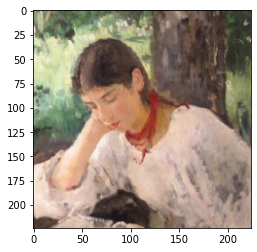

tensor([[[0.5490, 0.5843, 0.5412,  ..., 0.2471, 0.2471, 0.2588],
         [0.5686, 0.5255, 0.5294,  ..., 0.2275, 0.2392, 0.2706],
         [0.5412, 0.5255, 0.5255,  ..., 0.2196, 0.2431, 0.2627],
         ...,
         [0.3098, 0.3216, 0.3216,  ..., 0.7255, 0.7216, 0.7216],
         [0.3294, 0.3216, 0.3294,  ..., 0.7255, 0.7176, 0.6902],
         [0.3294, 0.3098, 0.3176,  ..., 0.7176, 0.7059, 0.6588]],

        [[0.5961, 0.6392, 0.6039,  ..., 0.2627, 0.2627, 0.2706],
         [0.6157, 0.5882, 0.6000,  ..., 0.2471, 0.2588, 0.2902],
         [0.5961, 0.5882, 0.5961,  ..., 0.2353, 0.2588, 0.2784],
         ...,
         [0.2314, 0.2431, 0.2431,  ..., 0.6196, 0.6157, 0.6118],
         [0.2510, 0.2431, 0.2510,  ..., 0.6157, 0.6039, 0.5804],
         [0.2510, 0.2314, 0.2353,  ..., 0.6078, 0.5961, 0.5569]],

        [[0.4745, 0.5098, 0.4706,  ..., 0.1843, 0.1804, 0.1961],
         [0.4941, 0.4627, 0.4667,  ..., 0.1686, 0.1804, 0.2118],
         [0.4784, 0.4627, 0.4706,  ..., 0.1608, 0.1843, 0.

In [476]:
#Data loading
from torchvision import datasets, transforms, utils

transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder("dataset_updated/training_set/train",transform=transform)
loader = data.DataLoader(dataset, batch_size = 4, shuffle = True)

images, labels = next(iter(loader))


img = images[0]
plt.imshow(transforms.functional.to_pil_image(img))
plt.show()
print(img)
img2 = img.numpy()

In [477]:
#LAB transform

def rgb2lab(img):
    print(img.shape)
    img = img.transpose((1,2,0))
    return color.rgb2lab(img)  

rgb2lab(img2)

(3, 224, 224)


array([[[ 61.143898 , -10.061502 ,  14.908684 ],
        [ 65.11756  , -11.037498 ,  15.526795 ],
        [ 61.542305 , -12.064398 ,  15.996992 ],
        ...,
        [ 27.508003 ,  -5.7186785,  11.627424 ],
        [ 27.486069 ,  -5.888939 ,  12.236303 ],
        [ 28.498123 ,  -5.0749035,  11.102146 ]],

       [[ 63.044273 , -10.011047 ,  14.816952 ],
        [ 60.05906  , -11.779934 ,  15.015423 ],
        [ 61.01493  , -12.837023 ,  15.791452 ],
        ...,
        [ 25.650513 ,  -6.215155 ,  11.6081295],
        [ 26.977863 ,  -6.1846075,  11.519313 ],
        [ 30.47033  ,  -6.1056166,  11.299313 ]],

       [[ 61.01465  , -10.656953 ,  14.145803 ],
        [ 60.05906  , -11.779934 ,  15.015423 ],
        [ 60.676224 , -12.512356 ,  14.751029 ],
        ...,
        [ 24.425957 ,  -5.6075454,  11.219615 ],
        [ 27.090302 ,  -5.553946 ,  11.04539  ],
        [ 29.25761  ,  -5.684823 ,  11.515272 ]],

       ...,

       [[ 26.793842 ,   7.333815 ,   8.982759 ],
        [ 2

In [478]:
#Color stats (auxiliary functions)

def getDiscretisedColor(a,b,gridSize):
    a = np.round(a/gridSize) * gridSize
    b = np.round(b/gridSize) * gridSize
    return (a,b)

def getMatrixIndex(a,b,gridSize):
    i = (a + 500) / gridSize
    j = (b + 200) / gridSize
    return (int(i),int(j))

def getColorValue(i,j,gridSize):
    a = i * gridSize - 500
    b = j * gridSize - 200
    return (a,b)

(3, 224, 224)
(224, 224, 3)
[[[ 63.044273   -10.011047    14.816952  ]
  [ 60.05906    -11.779934    15.015423  ]
  [ 61.01493    -12.837023    15.791452  ]
  [ 59.393578   -13.440073    16.293335  ]
  [ 56.6521     -11.676759    15.847611  ]
  [ 56.513893   -10.3537445   15.680897  ]
  [ 60.307205    -8.545219    15.441263  ]
  [ 80.17634     -7.122427    13.801586  ]
  [ 83.06509     -5.1651      12.685453  ]
  [ 63.763084    -4.2729673   12.603903  ]
  [ 55.650986    -4.568875    12.27591   ]
  [ 55.86418     -3.4444332   11.453319  ]
  [ 61.307426    -9.006559    12.905682  ]
  [ 60.59011     -9.087414    15.832925  ]
  [ 55.17196     -7.7185926   20.126629  ]
  [ 59.198082    -5.123228    21.850086  ]
  [ 70.791275    -1.8388629   19.965054  ]
  [ 68.11296     -0.16322732  17.284893  ]
  [ 51.763634    -0.9866059   15.491592  ]
  [ 52.40818     -3.465712    14.603937  ]
  [ 53.50625     -7.891834    16.062046  ]
  [ 54.37397    -11.767775    18.913578  ]
  [ 56.802773   -13.340294

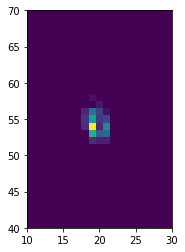

20
[(20, -10), (20, 0), (20, 10), (30, -10), (30, 0), (30, 10), (40, -20), (40, -10), (40, 0), (40, 10), (50, -20), (50, -10), (50, 0), (50, 10), (60, -20), (60, -10), (60, 0), (60, 10), (70, 0), (80, -10)]
[0.026785714285714284, 0.017857142857142856, 0.017857142857142856, 0.12053571428571429, 0.05357142857142857, 0.0625, 0.026785714285714284, 0.19196428571428573, 0.022321428571428572, 0.08928571428571429, 0.03125, 0.10714285714285714, 0.03125, 0.04017857142857143, 0.022321428571428572, 0.07142857142857142, 0.03571428571428571, 0.008928571428571428, 0.013392857142857142, 0.008928571428571428]


In [479]:
#Color stats

# need dataset express like that: list of images (as tensor) with dim H x W x 2 ...
image_test = rgb2lab(img2) # need to change dim order of color stat code... ?
#images = [np.random.rand(3,3,2) * 100]
images = [image_test[:][:][1:2]]
print(image_test.shape)
print(images[0])

# Initiate the proba distribution of ab pairs in the images dataset (discretised).
gridSize = 10
colorProbabilities = np.zeros((1000 // gridSize, 400 // gridSize))

# Compute the proba distribution of the ab pairs in the images dataset (discretised).
nbOfAnalysedPixels = 0
for image in images:
    for h in range (image.shape[0]):
        for w in range (image.shape[1]):
            (a,b) = getDiscretisedColor(image[h][w][0],image[h][w][1],gridSize)
            (i,j) = getMatrixIndex(a,b,gridSize)
            colorProbabilities[i][j] += 1
            nbOfAnalysedPixels += 1
colorProbabilities = colorProbabilities / nbOfAnalysedPixels

# Smooth the proba distribution of the ab pairs in the images dataset.
sigma = 5 # gaussian kernel parameter
#colorProbabilities = gaussian_filter(colorProbabilities, sigma=sigma) # is it ok ? add a lot of value in gamut... take proba treshold ?

# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities, interpolation='none')
plt.xlim(10, 30) # need to be dynamic !
plt.ylim(40, 70)
plt.show()

# Get the vector of proba of ab pairs that are "in gamut"
inGamutColors = []
inGamutColorsProbas = []
for i in range (colorProbabilities.shape[0]):
    for j in range (colorProbabilities.shape[1]):
        currentColorPorba = colorProbabilities[i][j]
        if currentColorPorba >= 0.001: # put a treshold ? if we use smoothing 
            (a,b) = getColorValue(i,j,gridSize)
            inGamutColors.append((a,b))
            inGamutColorsProbas.append(currentColorPorba)
        
Q = len(inGamutColors) 
p_smooth = torch.tensor(inGamutColorsProbas)
print(Q)
print(inGamutColors)
print(inGamutColorsProbas)
Q = 1 # to remove


In [480]:
#Define pixel weight vector (class rebalancing)

# Set the parameters (from paper, need empirical value).
lambda_uniform = 1/2 

# Compute a smooth version of the empirical pixel color distribution.
#p_smooth = p # how to do that ? gaussian kernel ? done at previous cell...

# Compute the weight vector.
pixelsWeights = torch.reciprocal((1 - lambda_uniform) * p_smooth + lambda_uniform / Q)

# Normalise the weight vector according to p_smooth (E[W] = 1).
E_W = torch.sum(p_smooth * pixelsWeights)
scale_factor = 1 / E_W
pixelsWeights = scale_factor * pixelsWeights 

print(pixelsWeights)

tensor([1.0595, 1.0687, 1.0687, 0.9708, 1.0325, 1.0238, 1.0595, 0.9126, 1.0641,
        0.9987, 1.0549, 0.9826, 1.0549, 1.0458, 1.0641, 1.0153, 1.0503, 1.0782,
        1.0735, 1.0782], dtype=torch.float64)


Define and instantiate Convolutional NN consistent with the description of the paper. Shown in table 4.

In [481]:
#NN def

from cv2 import dilate


class ColorizationCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.l_cent = 50.
        self.l_norm = 100.
        self.ab_norm = 110.
        
        channels_block_1 = 64
        channels_block_2 = 128
        channels_block_3 = 256
        channels_block_4 = 512
        channels_block_5 = 512 #dilated
        channels_block_6 = 512 #dilated
        channels_block_7 = 512 
        channels_block_8 = 128 # transpose convolution necessary

        nb_colour_bins = 313
        # first conv block : 2 convs. from luminosity image to 64 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock1 = nn.Sequential(nn.Conv2d(1,channels_block_1,(3,3), padding =1), 
                nn.ReLU(True), #inplace for memory efficiency can be used as no skip connections are used.
                nn.Conv2d(channels_block_1,channels_block_1,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.Relu(True),
                nn.BatchNorm2d(channels_block_1) #normalization over the 64 channels created
        )

        # second conv block. 2 covs. from 64 features to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock2 = nn.Sequential(nn.Conv2d(64,channels_block_2,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_2,channels_block_2,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_2)
        )

        # third conv block. 3 convs. from 64 to 128 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock3 = nn.Sequential(nn.Conv2d(channels_block_2,channels_block_3,(3,3), padding =1,), 
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_3,channels_block_3,(3,3), padding =1,stride=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_3)
        )

        # fourth conv block. 3 convs. from 256 to 512 features map from 3x3 kernels. 50% downsampling and normalization at the end.
        self.convBlock4 = nn.Sequential(nn.Conv2d(channels_block_3,channels_block_4,(3,3), padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_4,channels_block_4,(3,3), padding =1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_4)
        )
        
        #fifth conv block. 3 convs. no change in nb feature maps. 3x3 kernels with 2 dilation and 2 padding to not downscale. normalization at the end.

        self.convBlock5 = nn.Sequential(nn.Conv2d(channels_block_4,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_5,channels_block_5,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_5)
        )

        #sixth conv block. same as 5
        self.convBlock6 = nn.Sequential(nn.Conv2d(channels_block_5,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2),
                nn.ReLU(True),
                nn.Conv2d(channels_block_6,channels_block_6,(3,3),dilation=2,padding=2), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_6)
        )

        #seventh conv block : 3 convs with 3x3 kernels.
        self.convBlock7 = nn.Sequential(nn.Conv2d(channels_block_6,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,),
                nn.ReLU(True),
                nn.Conv2d(channels_block_7,channels_block_7,(3,3),padding =1,), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.BatchNorm2d(channels_block_7)
        )

        #eighth conv block : 1 inverse conv to upsample then 2 convs with 3x3 kernels default parameters. Final convolution with 1x1 for classification into a colour bin
        self.convBlock8 = nn.Sequential(nn.ConvTranspose2d(channels_block_7,channels_block_8,(4,4),stride = 2, padding =1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1),
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,channels_block_8,(3,3),padding = 1), #50% downsampling achieved with a 2 stride. 
                nn.ReLU(True),
                nn.Conv2d(channels_block_8,nb_colour_bins,kernel_size=1) #1x1 kernel for classification in each colour bin (value will be soft maxed for probability)
        )

        self.outputLayer = nn.Conv2d(nb_colour_bins,2,kernel_size=1,dilation=1, bias = False) # 1x1 kernel to get 2 channel values of a and b respectively
    
    def forward(self, luminosity_image):
        h1 = self.convBlock1((luminosity_image-self.l_cent)/self.l_norm) #normalize luminosity to be on scale of 0 to 100
        h2 = self.convBlock2(h1)
        h3 = self.convBlock3(h2)
        h4 = self.convBlock4(h3)
        h5 = self.convBlock5(h4)
        h6 = self.convBlock6(h5)
        h7 = self.convBlock7(h6)
        h8 = self.convBlock8(h7)

        colour_bin_proba = (nn.Softmax(dim=1))(h8)
        output = self.outputLayer(colour_bin_proba)
        upscaled_output = (nn.Upsample(scale_factor=4, mode='bilinear'))(output) # bilinear upscale to agree with input image size 

        return upscaled_output * self.ab_norm # denormalize to cover whole ab value range
        


ModuleNotFoundError: No module named 'cv2'

Define optimizer

In [ ]:
#ADAM


Define Loss

In [ ]:
#Convert a true image Y to pixels color distributions Z (soft encoding)

# to implement...
def getColorDistribution(Y):
    return 

In [ ]:
#Convert the pixel color distributions in Z[HxWxQ] to true picture estimate Y[HxWxQ] (point estimate)

# No need to be very efficient because only use when we predict (after training) ? difficult with tensor operation

def getPictureEstimate(Z,T):
    # Initiate a tensor to store the image estimated from Z.
    Y_estimate = torch.zeros(Z.shape[0], Z.shape[1], 2)
    
    # Estimate the Lab color for each pixel of the image.
    for h in range (Y_estimate.shape[0]):
        for w in range (Y_estimate.shape[1]):
            # Re-ajust the temperture of the current distribution.
            reajustedDistribution = torch.exp(torch.log10(Z[h][w]) / T)  / torch.sum(torch.exp(torch.log10(Z[h][w]) / T), 2) # check again...

            # Compute the anneled-mean of the current distribution. 
            a, b = 0, 0
            for q in range (Z.shape[2]):
                a += reajustedDistribution[q] * inGamutColors[q][0]
                b += reajustedDistribution[q] * inGamutColors[q][1]
            
            # Estimate the Lab color for the current pixel.
            Y_estimate[h][w][0] = a
            Y_estimate[h][w][1] = b
    
    # Return the estimated picture.
    return Y_estimate

In [ ]:
#v(Z_hw) weight in paper (section 2)

def getPixelsWeights(Z):
    W = torch.argmax(Z, dim=2)
    for i in range(W.size(dim=0)):
        for j in range(W.size(dim=1)):
            W[i,j] = pixelsWeights(W[i,j])

    return W

In [ ]:
#loss function 

def multinomialCrossEntropyLoss(Z_estimate, Z):
    W = getPixelsWeights(Z)
    L = - sum(W * torch.sum(Z * torch.log10(Z_estimate), dim=2))

    return L
    

Main training loop and additional function TBD